In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'ma' # ticker symbol
train = 1 # 1 for train, 0 for pass
days_ahead = 1 # for predicting 1 day ahead
cv = 5 # number of cross validation folds
model_name = 'Random Forest Classifier' # for display on charts, not a tuning parameter

In [3]:
# Extract, Transform, Load, and Train Test Split
# aapl start date: 12/12/1980, trained 12/23/20
# tsla start date: 06/29/2010, trained 12/23/20
# vbiv start date: 09/04/2002, trained 12/23/20
# vgt start date: 01/26/2004, trained 12/23/20
# idex start date: 05/23/2007, trained 12/23/20
# iyw start date: 05/15/2000, trained 12/23/20
# 
start_dates = {'aapl':'12/12/1980'
               , 'acy': '01/18/1998'
               , 'amd': '03/17/1980'
               , 'baba': '09/15/2014'
               , 'bac': '02/19/1973'
               , 'crm': '06/23/2004'
               , 'esgv': '09/16/2018'
               , 'goog': '08/16/2004'
               , 'ibm': '01/02/1962'
               , 'idex': '05/23/2007'
               , 'intc': '03/16/1980'
               , 'iyw': '05/15/2000'
               , 'ma': '05/21/2006'
               , 'msft': '03/10/1986'
               , 'nio': '09/10/2018'
               , 'nvda': '01/22/1999'
               , 'pypl': '07/05/2015'
               , 'tsla': '06/29/2010'
               , 'v': '03/16/2008'
               , 'vbiv': '09/04/2002'
               , 'vgt': '01/26/2004'
              }
X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)

In [4]:
stock_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction
Date,,,,,,,,,,,,
2020-12-16,334.000000,329.250000,333.959991,332.100006,3393300.0,332.100006,0.005569,0.014427,-0.004646,0.011969,-0.002779,1
2020-12-17,338.329987,333.399994,334.540009,336.899994,2725500.0,336.899994,-0.007054,0.014787,0.014453,0.011364,0.003276,-1
2020-12-18,341.600006,334.350006,336.510010,340.329987,8443700.0,340.329987,-0.011352,0.021684,0.010181,0.007379,0.007786,-1
2020-12-21,336.149994,327.239990,333.209991,334.369995,3642500.0,334.369995,-0.003481,0.027228,-0.017512,0.013016,0.002005,1
2020-12-22,335.220001,331.600006,334.160004,332.239990,2403100.0,332.239990,0.005746,0.010917,-0.006370,0.013023,-0.000779,-1
2020-12-23,335.209991,329.029999,334.130005,329.230011,2760600.0,329.230011,0.014665,0.018782,-0.009060,0.013492,-0.001662,1
2020-12-24,336.369995,330.350006,330.649994,336.000000,1308900.0,336.000000,-0.016180,0.018223,0.020563,0.015450,-0.000440,1
2020-12-28,345.589996,336.869995,337.859985,344.470001,3449100.0,344.470001,-0.019564,0.025885,0.025208,0.019070,0.002566,-1
2020-12-29,348.750000,344.760010,347.779999,346.660004,2822700.0,346.660004,0.003220,0.011573,0.006358,0.015427,0.007340,1


In [5]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
if train == 1:
    a.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)
elif train == 0:
    pass

/home/david/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.72723905 0.72723905 0.72723905]
  warnings.warn(


In [6]:
# Load RandomForextClassifier Model
rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

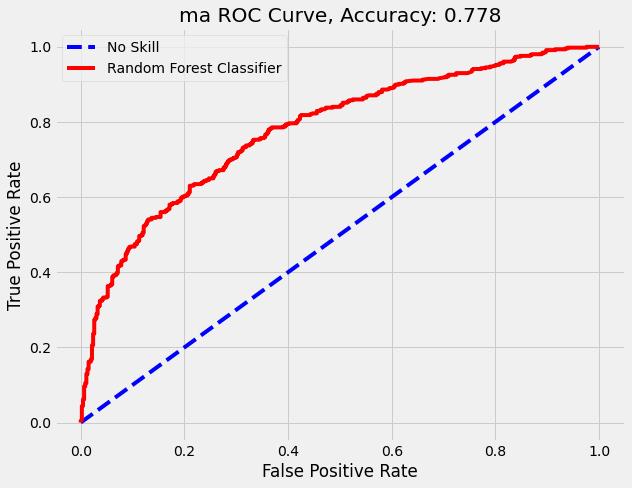

In [7]:
# ROC Curve
a.roc_plot(y_test, y_probs, stock_name, model_name)

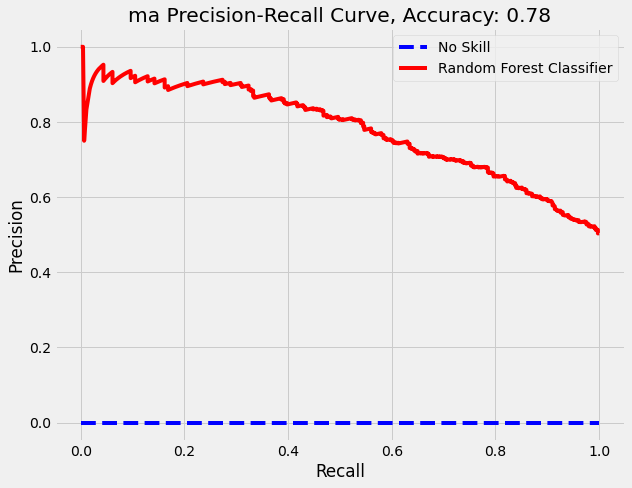

In [8]:
# Precision Recall Curve
a.prec_recall(y_test, y_probs, stock_name, model_name)

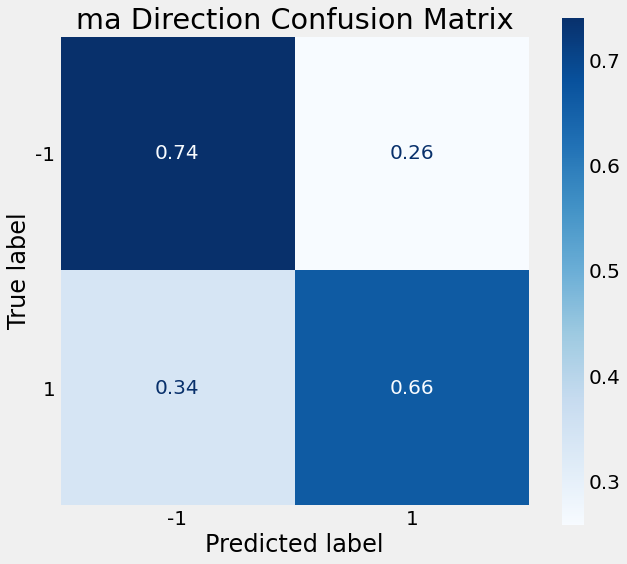

In [9]:
# Confusion Matrix
a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
a.cross_validation(rfc_model
                   , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
                   , stock_df['direction']
                   , cv = 5
                  )

'5 Fold Cross-Validation Score for First RF Model: 0.71642514226399'

In [11]:
# Prediction, use last day of data
stock_df.iloc[-1]

High          3.578200e+02
Low           3.472100e+02
Open          3.486800e+02
Close         3.555500e+02
Volume        4.200200e+06
Adj Close     3.555500e+02
oc           -1.970287e-02
hl            3.055792e-02
adj           2.564468e-02
5stdev_adj    1.495094e-02
5sma_adj      1.374281e-02
direction    -1.000000e+00
Name: 2020-12-30 00:00:00, dtype: float64

In [12]:
import numpy as np
last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-1]
last

oc           -0.019703
hl            0.030558
5stdev_adj    0.014951
5sma_adj      0.013743
Name: 2020-12-30 00:00:00, dtype: float64

### Prediction...

In [13]:
if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {stock_name}')
else:
    print(f'Sell or hold {stock_name}')

Sell or hold ma


In [14]:
# returns on strategy column
stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [15]:
stock_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction,prediction,returns
Date,,,,,,,,,,,,,,
2020-12-23,335.209991,329.029999,334.130005,329.230011,2760600.0,329.230011,0.014665,0.018782,-0.009060,0.013492,-0.001662,1,1,0.020563
2020-12-24,336.369995,330.350006,330.649994,336.000000,1308900.0,336.000000,-0.016180,0.018223,0.020563,0.015450,-0.000440,1,-1,-0.025208
2020-12-28,345.589996,336.869995,337.859985,344.470001,3449100.0,344.470001,-0.019564,0.025885,0.025208,0.019070,0.002566,-1,-1,-0.006358
2020-12-29,348.750000,344.760010,347.779999,346.660004,2822700.0,346.660004,0.003220,0.011573,0.006358,0.015427,0.007340,1,1,0.025645
2020-12-30,357.820007,347.209991,348.679993,355.549988,4200200.0,355.549988,-0.019703,0.030558,0.025645,0.014951,0.013743,-1,-1,-0.001444


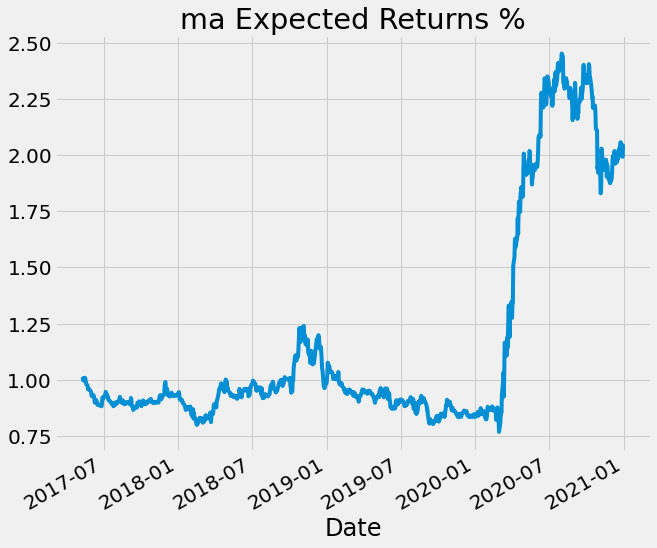

In [16]:
# Don't trade every day!
import matplotlib.pyplot as plt
test_length = len(y_test)
(stock_df['returns'][-test_length:] + 1).cumprod().plot()
plt.title(f'{stock_name} Expected Returns %');

In [17]:
# Model returns if bought on predictions of 1
returns_on_ones = []
for idx in range(-test_length, 0):
    if stock_df['prediction'][idx] == 1:
        returns_on_ones.append(1 + stock_df['returns'][idx])

returns = 1
for x in returns_on_ones:
    returns *= x
returns

2.734169711364361

In [18]:
# multiple times original investment, not bad but...

In [19]:
# If purchased in 2012 and left it until now
test_idx = int(len(stock_df)*0.75)
(stock_df['Close'][-1] - stock_df['Close'][-test_idx]) /stock_df['Close'][-test_idx]

13.301515905236052

In [20]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/